# Generate Graphs

In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
import networkx as nx
import numpy as np
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend


seed = 666
num_rows = 3
num_cols = 2
neutral_atom = ColdQuantaSimBackend(rows=num_rows, cols=num_cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

np.random.seed(seed)
g = nx.Graph(coupling_map)

num_graphs = 10
graphs = []
# for _ in range(num_graphs):
#     h = nx.Graph(g)
    
#     for edge in h.edges:
#         h.remove_edge(*edge)
    
#     for edge in g.edges:
#         h.add_weighted_edges_from([(edge[0], edge[1], np.random.randint(1, 4))]) 
#     graphs.append(h)
for _ in range(num_graphs):
    graphs.append(nx.generators.random_graphs.random_regular_graph(3, num_cols*num_rows))

In [3]:
def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

In [4]:
def Z(i, j, num_qubits):
    rtn = np.eye(1)
    z = np.array([[1, 0], [0, -1]])
    for k in range(num_qubits):
        if k == i or k == j:
            rtn = np.kron(rtn, z)
        else:
            rtn = np.kron(rtn, np.eye(2))
    return rtn

In [5]:
def cost(density_matrix, num_qubits, weights):
    rtn = 0
    for edge, weight in weights.items():
        rtn += .5 * weight * (1 - np.trace(Z(*edge, num_qubits).dot(density_matrix)))
    return rtn

In [6]:
import dill as dill

In [ ]:
with open("test.pkl", 'wb') as test:
    dill.dump(['foo', 'bar'], test)

In [8]:
with open("test.pkl", 'rb') as test:
    print(dill.load(test))

['foo', 'bar']


In [7]:
from classical_optimization.qaoa_circuits import produce_gammas_betas, maxcut_qaoa_circuit, estimate_cost
from qiskit import Aer, execute
from qiskit.providers.aer.extensions import snapshot_density_matrix
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
discretization = 50
max_gamma = 2*np.pi
max_beta = np.pi
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)
gammas = gammas[0:int(len(gammas)/2)]

In [8]:
graph = nx.generators.classic.complete_graph(num_rows*num_cols)

/home/ampolloreno/repos/qaoa/classical_optimization/classical_optimization/qaoa_circuits.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(ticks)
/home/ampolloreno/repos/qaoa/classical_optimization/classical_optimization/qaoa_circuits.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels(ticks)


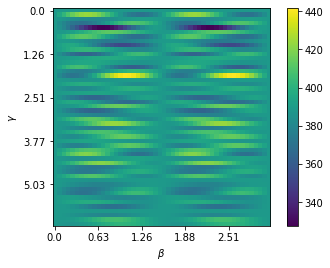

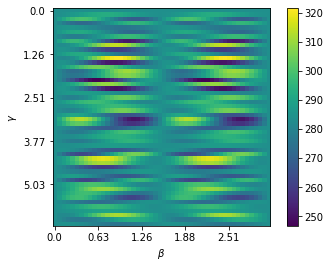

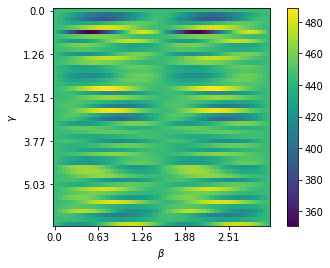

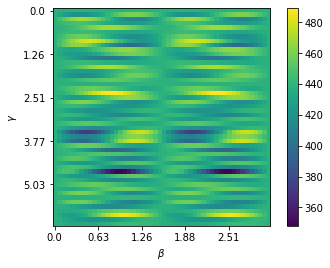

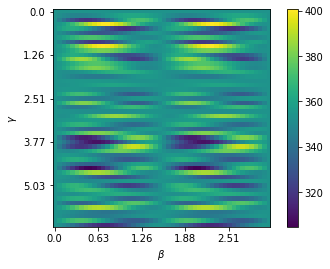

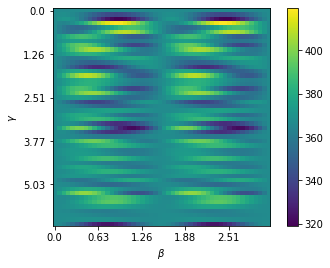

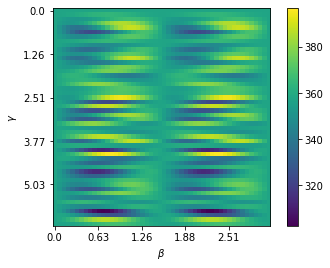

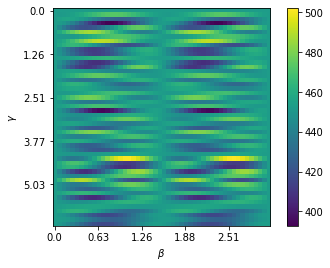

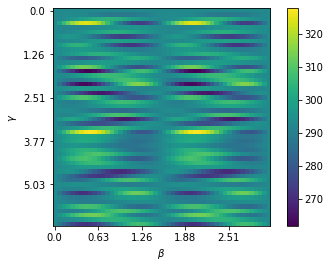

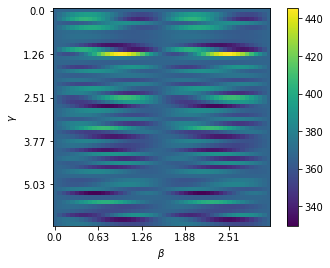

In [9]:
from classical_optimization.qaoa_circuits import plot_landscape
import matplotlib.pyplot as plt
for _ in range(10):
    for edge in graph.edges:   
        for edge in graph.edges:
            graph.remove_edge(*edge)
            # We're going to ignore weights for n ow.
            graph.add_weighted_edges_from([(edge[0], edge[1], np.random.randint(1,100))]) 

    noise_model = create_noise_model(cz_fidelity=1)
    num_qubits = num_rows*num_cols


    simulator = Aer.get_backend('qasm_simulator')
    backend_options = {}

    experiments = []
    for gamma in gammas:
        for beta in betas:
            circuit = maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=num_rows, cols=num_cols, weights=weights(graph), measure=False, density_matrix=True)
            experiments.append(circuit)

    job = execute(experiments, backend=simulator,  noise_model=noise_model, backend_options=backend_options)    
    outputs = [result.data.snapshots.density_matrix['output'][0]['value'] for result in job.result().results]
    # The diagonal is real, so we take the first element.
    expectations = [cost(np.array(output)[:, :, 0], num_qubits=num_qubits, weights=weights(graph)) for output in outputs]
    landscape = np.zeros((discretization, discretization))
    for i, gamma in enumerate(gammas):
        for j, beta in enumerate(betas):
            landscape[i][j] = expectations[i*len(betas) + j]
    plot_landscape(landscape, max_gamma, max_beta)  
    plt.show()

In [10]:
from classical_optimization.qaoa_circuits import plot_landscape
import matplotlib.pyplot as plt
for i in range(num_graphs):
    with open(f'graph{i}.pkl', 'rb') as graphfile:
        graph, landscape = dill.load(graphfile)
    plot_landscape(landscape, max_gamma, max_beta)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'graph0.pkl'

> <ipython-input-10-37a0c0932f26>(4)<module>()
      2 import matplotlib.pyplot as plt
      3 for i in range(num_graphs):
----> 4     with open(f'graph{i}.pkl', 'rb') as graphfile:
      5         graph, landscape = dill.load(graphfile)
      6     plot_landscape(landscape, max_gamma, max_beta)

ipdb> c


In [11]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost

np.random.seed(666)
shots_per_point = 10
reprate = 50 #Hz
# Does the system need to be recalibrated periodically?
one_hour = 60 * 60 #seconds

history = []
def store_log(func):
    def logged_func(x):
        history.append(x)
        return func(x)
    return logged_func

@store_log
def gamma_beta_objective(gamma_beta):
    # The cut value is the expectation value, minima of the negation correspond to maxima.
    return -execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[1], beta=gamma_beta[0],
                                                   num_shots=shots_per_point,
                                                   simulator=simulator,
                                                   coupling_map=coupling_map,
                                                   weights=weights(graph),
                                                   rows=num_rows,
                                                   cols=num_cols,
                                                   noise_model=noise_model,
                                                   seed=np.random.randint(0,1000000))

# We can control the maximum number of iterations, and we should fix the total number of function evaluations
# at the time we are considering. Additionally, we need to consider the number of shots to perform per evaluation.

# Then we need to sweep initial_temp, visit, and accept.
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    gamma_beta_objective,
    bounds=[(0, np.pi),
            (0, 2*np.pi)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    initial_temp=10,
    maxfun=one_hour*reprate,
    # It looks like the algorithm will randomly reinitialize if the temperature drops below a certain point. This seems
    # like it would only be useful if the scipy function reports the best found solution.
    restart_temp_ratio=1E-10,
    # Don't use local search around reported minima, for now.
    no_local_search=True)
result.fun = -result.fun

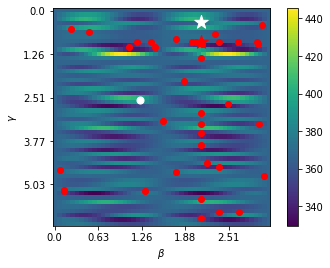

In [12]:
from classical_optimization.qaoa_circuits import plot_history_over_landscape
plot_history_over_landscape(history, landscape, discretization, max_gamma, max_beta, result)

In [19]:
def cutsize(set1, set2, g):
    cut = 0
    for s1 in set1:
        for s2 in set2:
            if g.get_edge_data(s1, s2) is not None:
                cut += g.get_edge_data(s1, s2)['weight']
    return cut

def maxcut(g, a=[], b=[], used=[]):
    for node in g.nodes:
        if node not in used:
            left = maxcut(g, list(a) + [node], list(b), list(used) + [node])[0]
            right = maxcut(g, list(a), list(b) + [node], list(used) + [node])[0]
            if left > right:
                a = list(a) + [node]
                b = list(b)
            else:
                a = list(a)
                b = list(b) + [node]
    # There are no unused nodes, we've reached a leaf.
    return cutsize(a, b, g), a, b
cutvalue = maxcut(graph)[0]

In [20]:
print(f"The maximum for p=1 is {np.max(landscape)}, while the maxcut is {cutvalue}, the solver gave {result.fun} at {result.x}. \
It used {len(history)} evaluations, with {shots_per_point} shots per point.")

The maximum for p=1 is 340.3985501794689, while the maxcut is 450, the solver gave 395.4 at [2.2739054  3.40451013]. It used 41 evaluations, with 10 shots per point.


In [9]:
from classical_optimization.qaoa_circuits import plot_landscape
import matplotlib.pyplot as plt
betas_gammas = []
for i in range(num_graphs):
    with open(f'graph{i}.pkl', 'rb') as graphfile:
        graph, landscape = dill.load(graphfile)
    print(np.argmax(landscape))

224
284
284
1515
224
224
224
224
224
284
